# Importing Modules

In [534]:
from dataclasses import dataclass, asdict
from dataclass_csv import DataclassReader
from typing import Optional
from enum import Enum
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest

from abc import abstractmethod

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Reading the Data

In [149]:
class InfillPattern(Enum):
    GRID = "grid"
    HONEYCOMB = "honeycomb"

In [150]:
class Material(Enum):
    ABS = "abs"
    PLA = "pla"

In [151]:
@dataclass
class ThreeDPrinterData:
    layer_height: float
    wall_thickness: int
    infill_density: int
    infill_pattern: InfillPattern
    nozzle_temperature: int
    bed_temperature: int
    print_speed: int
    material: Material
    fan_speed: int
    roughness: int
    tensile_strength: int
    elongation: float

In [152]:
FILENAME = './3dprinterdata_edited.csv'

In [512]:
def readCSVData(flname):
    with open(flname) as data_csv:
        reader = DataclassReader(data_csv, ThreeDPrinterData)
        reader.map('Tensile Strength').to('tensile_strength')
        reader.map('Elongation').to('elongation')
        data_objects = []
        for row in reader:
            data_objects.append(row)
    
    df = pd.DataFrame(data_objects)
    df['infill_pattern'] = df['infill_pattern'].map(lambda obj: obj.value)
    df['material'] = df['material'].map(lambda obj: obj.value)
    
    return df, df.columns

In [513]:
df, df_columns = readCSVData(FILENAME)

# Step - 1 : Exploratory Data Analysis

In [455]:
class GeneralStatistics:
    def __init__(self, data):
        self.data = data
        self.cor = self.data.corr()
        self.cat_features = ['infill_pattern', 'material']
        
    def counts(self):
        print("There are {} datapoints and {} features".format(self.data.shape[0], self.data.shape[1]))
        
    def isNull(self):
        total = sum(self.data.isnull().sum())
        print("There are {} null values in the dataset".format(total))
        
    def descriptiveStats(self):
        print("\nThis is the mean value of all the variables\n\n")
        return self.data.describe().T['mean']
    
    def pairwiseCorrelation(self):
        plt.figure(figsize = (12, 12))
        sns.heatmap(self.cor, cbar = True, annot = True, cmap = 'Blues')
        
    def correlatedFeatures(self, target, positive = 0.4, negative = -0.1):
        cor_target = self.cor[target]
        
        positive_cor_features = cor_target[cor_target >= positive]
        pos_corr = [(feature, value) for feature, value in zip(positive_cor_features.index, positive_cor_features.values) if feature not in target]
        
        negative_cor_features = cor_target[cor_target <= negative]
        neg_corr = [(feature, value) for feature, value in zip(negative_cor_features.index, negative_cor_features.values) if feature not in target]
        
        return {'target': target, 
                'postive_cor': pos_corr, 
                'negative_cor': neg_corr}
    
    def targetRelation(self, corr_stats):
        features = []
        out = {}
        for k, v in corr_stats.items():
            if k == 'target':
                target_var = v
            else:
                for (feature, score) in v:
                    features.append(feature)
        out = {'target': target_var, 'features': features}
        
        for feature in features:
            self.scatterPlot(feature, out['target'], self.data)
    
    def plotCategorical(self, x, y):
        if x in self.cat_features:
            self.boxPlot(x, y, self.data)
            
    def scatterPlot(self, x, y, data):
        sns.lmplot(x = x, y = y, data = data)
        
    def boxPlot(self, x, y, data):
        sns.boxplot(x = x, y = y, data = data, palette='rainbow')

In [456]:
statsObj = GeneralStatistics(df)

In [457]:
statsObj.counts()
statsObj.isNull()
statsObj.descriptiveStats()

There are 46 datapoints and 12 features
There are 0 null values in the dataset

This is the mean value of all the variables




layer_height            0.108696
wall_thickness          5.065217
infill_density         54.565217
nozzle_temperature    222.173913
bed_temperature        70.108696
print_speed            65.652174
fan_speed              50.543478
roughness             174.021739
tensile_strength       20.065217
elongation              1.665217
Name: mean, dtype: float64

### Target = 'roughness'

In [458]:
roughness_corr = statsObj.correlatedFeatures(target = 'roughness')
roughness_corr

{'target': 'roughness',
 'postive_cor': [('layer_height', 0.773679521409528),
  ('nozzle_temperature', 0.40997688511573716)],
 'negative_cor': [('wall_thickness', -0.19931620751820497)]}

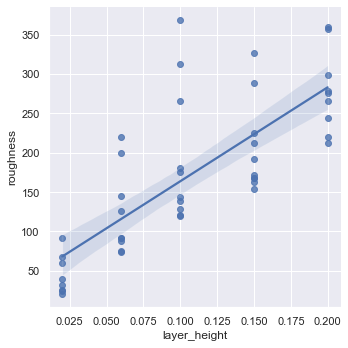

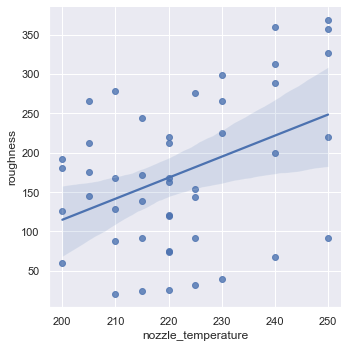

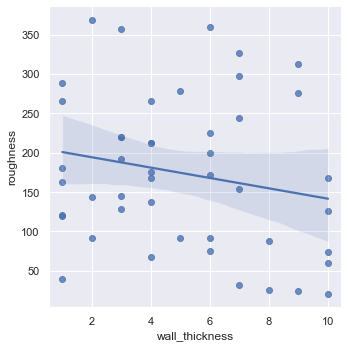

In [459]:
statsObj.targetRelation(roughness_corr)

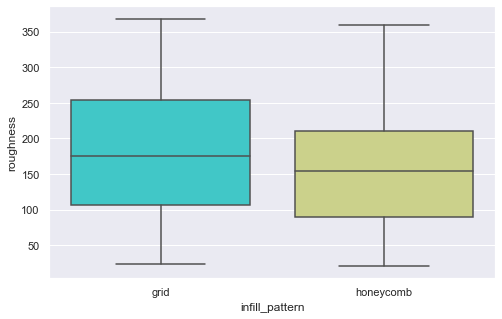

In [460]:
statsObj.plotCategorical(x = 'infill_pattern', y = 'roughness')

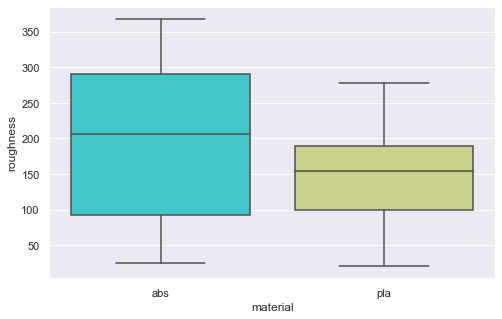

In [462]:
statsObj.plotCategorical(x = 'material', y = 'roughness')

### Target = 'tensile_strength'

In [405]:
tensile_corr = statsObj.correlatedFeatures(target = 'tensile_strength')
tensile_corr

{'target': 'tensile_strength',
 'postive_cor': [('wall_thickness', 0.4299783187945704),
  ('elongation', 0.8374528823899959)],
 'negative_cor': [('nozzle_temperature', -0.41892249542050286),
  ('bed_temperature', -0.27459601199575845),
  ('print_speed', -0.26858492509302073),
  ('fan_speed', -0.2745960119957587)]}

These are scatterplots


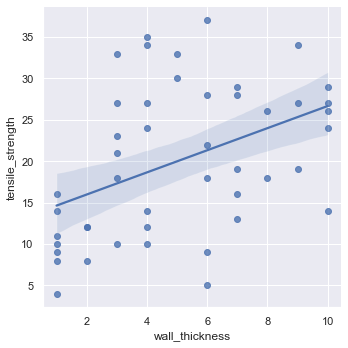

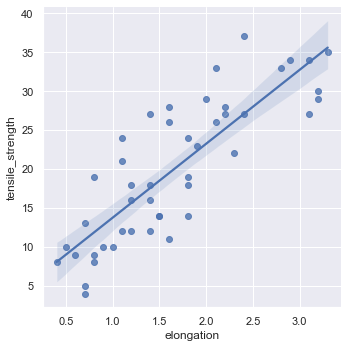

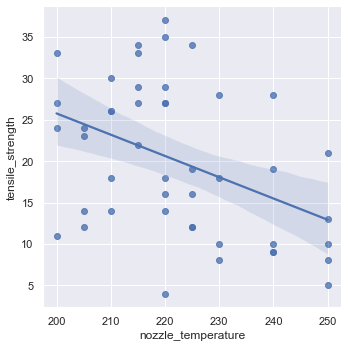

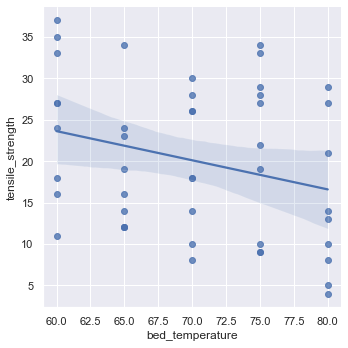

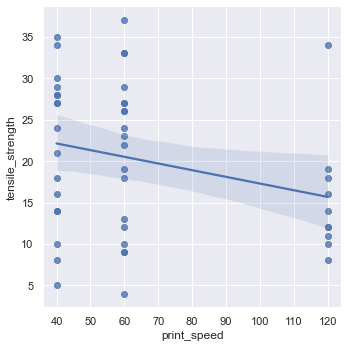

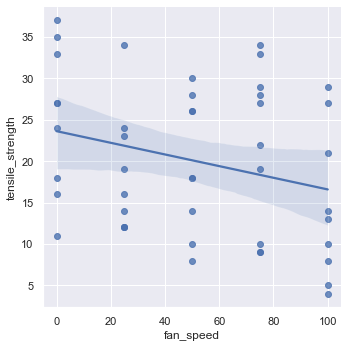

In [406]:
statsObj.targetRelation(tensile_corr)

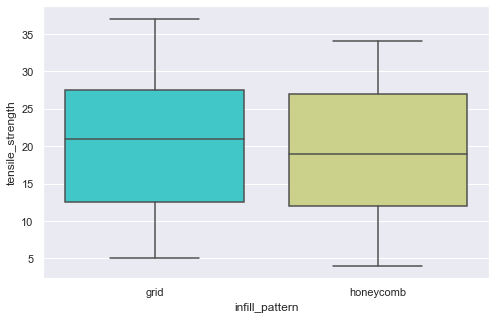

In [461]:
statsObj.plotCategorical(x = 'infill_pattern', y = 'tensile_strength')

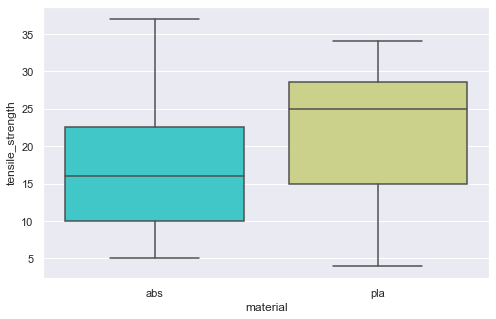

In [463]:
statsObj.plotCategorical(x = 'material', y = 'tensile_strength')

### Target = 'elongation'

In [407]:
elongation_corr = statsObj.correlatedFeatures(target = 'elongation')
elongation_corr

{'target': 'elongation',
 'postive_cor': [('layer_height', 0.49325265653442163),
  ('tensile_strength', 0.8374528823899959)],
 'negative_cor': [('nozzle_temperature', -0.5254619483514119),
  ('bed_temperature', -0.29082737182897916),
  ('print_speed', -0.23063858127718095),
  ('fan_speed', -0.29082737182897994)]}

These are scatterplots


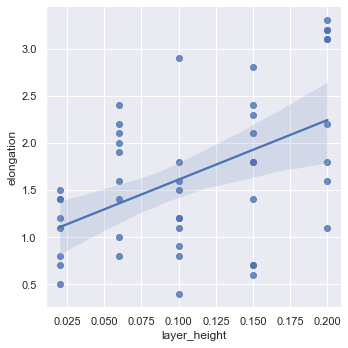

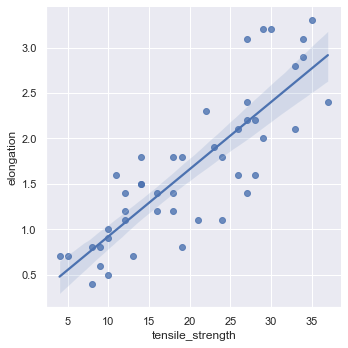

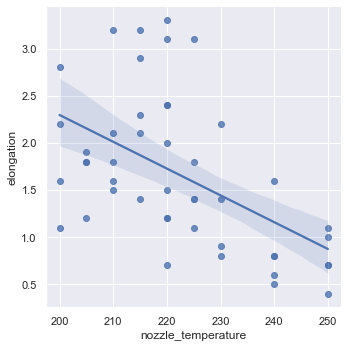

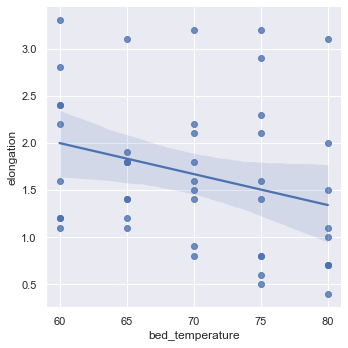

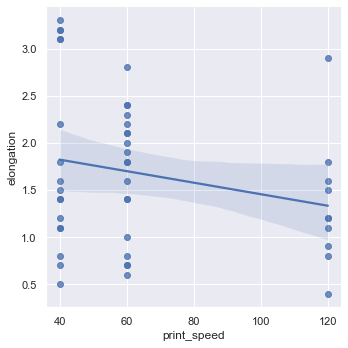

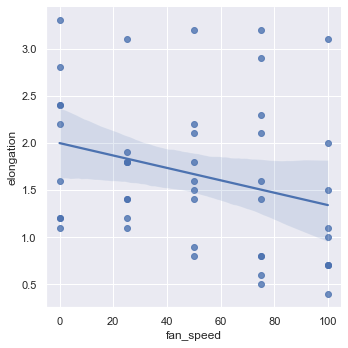

In [408]:
statsObj.targetRelation(elongation_corr)

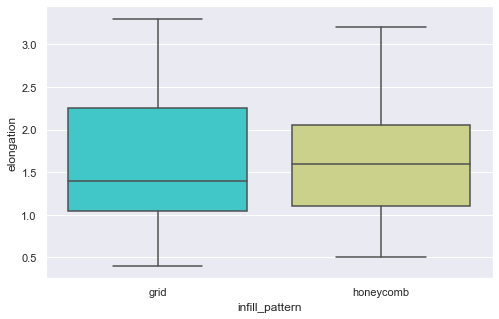

In [464]:
statsObj.plotCategorical(x = 'infill_pattern', y = 'elongation')

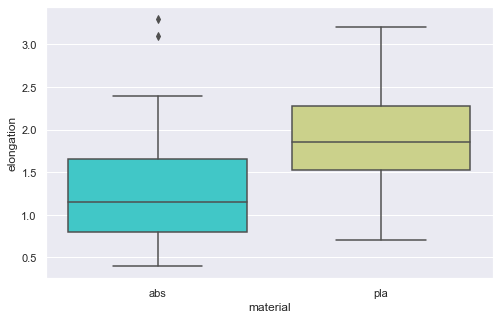

In [465]:
statsObj.plotCategorical(x = 'material', y = 'elongation')

### Pairwise Correlation

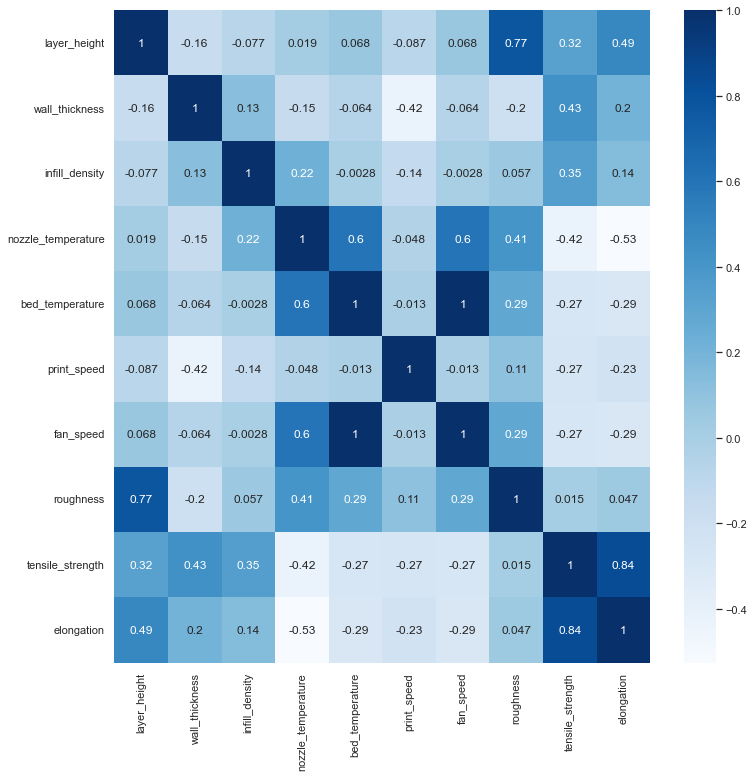

In [409]:
statsObj.pairwiseCorrelation()

### Descriptive Statistical Insights -
A good start is to look at some descriptive statistics -

1. There are in total 46 datapoints
2. There are two categorical variables which need to be one-hot encoded
3. The mean of each term shows that the data needs to be normalized before the model is trained.
4. **Correlation** with the response variable : 
    * 'roughness' : 'layer_height'(0.77) and 'nozzle_temperature'(0.41) are **positively** correlated AND 'wall_thickness' (-0.20) is **negatively** correlated
    * 'tensile_strength' : 'wall_thickness'(0.43) and 'elongation'(0.84) are **positively** correlated 'nozzle_temperature'(-0.42), 'bed_temperature'(-0.27), 'print_speed'(-0.27), 'fan_speed'(-0.27) are **negatively** correlated
    * 'elongation': 'layer_height'(0.49) and 'tensile_strength'(0.84) are **positively** correlated and 'nozzle_temperature'(-0.52), 'bed_temperature'(-0.29), 'print_speed'(-0.23) and 'fan_speed'(-0.29) are **negatively** correlated
5. For **Categorical Variables** (infill_pattern and 'material')-
    * There is a similar distribution of "infill_pattern" and "material" with respect to the target feature "roughness" with a mean value close to 200 resulting in roughness
    * For "tensile_strength" both the values of "infill_pattern" i.e. "grid" and "honeycomb" have similar distributions resulting a mean value of approx 20 for the tensile_strength.
    * 'material' values 'pla' yields a mean of 25 'tensile_strength' and 'abs' yields a mean of '15' in 'tensile_strength'. This shows a distinct variability.
    * Both 'infill_pattern' values 'grid' and 'honeycomb' results in a similar distribution of response variable 'elongation' with a mean value close to 1.5
    * There is a high variability of the response 'elongation' with respect to the type of 'materials'. The mean value of 'elongation' is close to 1 for 'material' type 'abs' and the mean value of 'elongation' is close to 2 for 'material' type 'pla'

# Normality Test
An important decision point whether to use a Parametric or Non-parametric statistical methods depends on how the data is distributed and how a sample is drawn from a given distribution.
* Parametric Statistical Methods : It assumes that the data follows a Gaussian or Normal distribution.
* Non-parametric Statistical Methods : The distribution of data need not be a normal distribution.

#### Quantile-Quantile (QQ plot)
This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups, called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis. A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

In [476]:
def qqPlot(target, data):
    np.random.seed(101)
    qqplot(data[target], line='s')
    plt.show()

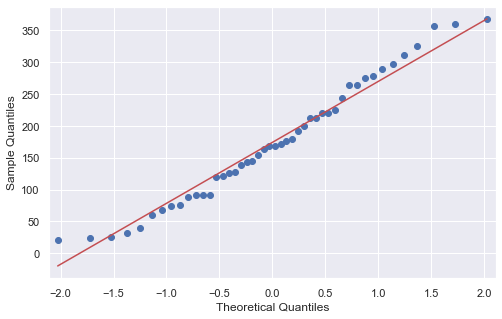

In [477]:
qqPlot('roughness', df)

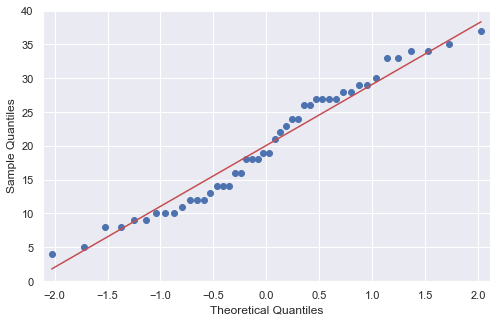

In [478]:
qqPlot('tensile_strength', df)

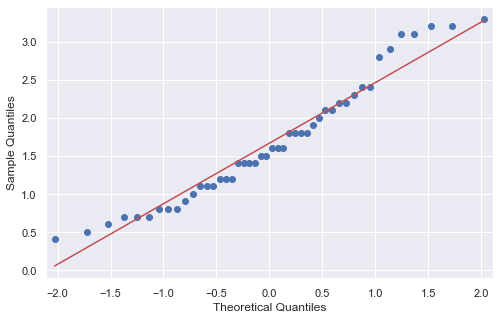

In [479]:
qqPlot('elongation', df)

### Normality Insights - Part 1
* From the QQ plot we can see that "Roughness" is very close to a Gaussian Distribution.
* However 'tensile_strength' and 'elongation' have some deviations from the Gaussian Distribution, but it is not that different.

So, we will test it further using few Statistical Normality Tests.
The following tests assume that the sample was drawn from a Gaussian Distribution. This is called the Null Hypothesis (H0). A threshold level is chosen called alpha, typically 5 % (or 0.05), that is used to interpret the p-value

* p <= alpha : reject H0 (or accept Alternative Hypothesis H1), i.e. not normal
* p > alpha : fail to reject H0, i.e. normal

So, in general we are seeking results with a larger p-value to confirm that our sample was likely drawn from a Gaussian Distribution.

#### Test - 1 : Shapiro-Wilk Test

In [499]:
def shapiroWilkTest(target, data):
    np.random.seed(1)
    stat, p = shapiro(data[target])
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [500]:
shapiroWilkTest('roughness', df)

Statistics = 0.967, p = 0.205
Sample looks Gaussian (fail to reject H0)


In [501]:
shapiroWilkTest('tensile_strength', df)

Statistics = 0.955, p = 0.075
Sample looks Gaussian (fail to reject H0)


In [502]:
shapiroWilkTest('elongation', df)

Statistics = 0.947, p = 0.037
Sample does not look Gaussian (reject H0)


#### Test - 2 : D’Agostino’s K^2 Test
It calculates the summary statistics from the data, namely Skewness (3rd Moment) and Kurtosis (4th Moment) to determine if the data distribution departs from the normal distribution.

* Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
* Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.

In [503]:
def dAgostinoTest(target, data):
    np.random.seed(1)
    stat, p = normaltest(data[target])
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [504]:
dAgostinoTest('roughness', df)

Statistics = 2.784, p = 0.249
Sample looks Gaussian (fail to reject H0)


In [505]:
dAgostinoTest('tensile_strength', df)

Statistics = 9.397, p = 0.009
Sample does not look Gaussian (reject H0)


In [506]:
dAgostinoTest('elongation', df)

Statistics = 3.201, p = 0.202
Sample looks Gaussian (fail to reject H0)


### Normality Insights - Part 2
* In Shapiro-Wilk test : 'roughness' and 'tensile_strength' came out to be drawn from a Gaussian (normal) distribution. However 'elongation' seems to be non-normal.
* In D Agostino's k^2 test : 'roughness' and 'elongation' came out to be drawn from a Gaussian (normal) distribution. However 'tensile_strength' seems to be non-normal.

So, we will definitely consider 'roughness' coming from a normal distribution and will go for a parameteric statistical model.
And, 'tensile_strength' and 'elongation' seem to be soft fail, so we will try out both parametric and non-parametric statistical model.

# Step - 2 : Predictive Analysis

In [554]:
# The data preparation for the model -

def createDataLoader(target, cols, data, test_size = 0.2):
    features = []
    for col in cols:
        if col == target:
            continue
        features.append(col)
        
    y = data[target]
    X = data[features]
    
    # Getting dummy encoding for 'infill_pattern' and 'material'
    X = pd.get_dummies(data = X, drop_first=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
    
    data_loader = {'X_train': X_train,
                   'X_test': X_test,
                   'y_train': y_train,
                   'y_test': y_test,
                   'X_features': features,
                   'target': target}
    
    return data_loader

In [558]:
class Model():
    '''
        It is an abstract base class for all the models. The subclas should implement the following methods -
        1. initialize() : To initialize the model 
        2. train() : To train the model
        3. predict() : To predict using the trained model
    
    '''
    
    @abstractmethod
    def initialize(self):
        raise NotImplementedError
    
    @abstractmethod
    def modelTrain(self):
        raise NotImplementedError
    
    @abstractmethod
    def modelPredict(self):
        raise NotImplementedError

In [559]:
class LinearRegressionModel(Model):
    
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        
    def initialize(self):
        self.model = LinearRegression()
        
    def modelTrain(self, data_loader):
        X_train = data_loader['X_train']
        y_train = data_loader['y_train']
        self.model.fit(X_train, y_train)
        return self.model
    
    def modelPredict(self, data_loader):
        X_test = data_loader['X_test']
        predictions = self.model.predict(X_test)
        return predictions

In [560]:
lm_obj = LinearRegressionModel()

In [561]:
lm_obj.initialize()

In [564]:
data_loader = createDataLoader('roughness', df_columns, df, test_size = 0.2)

In [566]:
lm_roughness = lm_obj.modelTrain(data_loader)

In [569]:
preds_roughness = lm_obj.modelPredict(data_loader)

In [570]:
preds_roughness

array([251.2376666 , 249.48349358, 186.23780744, 213.72745999,
        25.61715795])

In [ ]:

plt.scatter(y_test, predictions)